# Predict Greenweez Churners


We are going to look at the Greenweez client database!

We want to identify which of our Greenweez customers will reconvert (make a second purchase) within 3 months.

**Our data**: 
We have access to the sales from 2019 to 2021.
Let's take a look


## Data exploration


In [ ]:
import os

# Charger le chemin depuis le fichier texte
with open(".path_repo.txt", "r") as f:
    path_repo = f.read().strip()

os.chdir(path_repo)

In [2]:
import pandas as pd

df = pd.read_csv('data\gwz_churn.csv')

<>:3: SyntaxWarning: invalid escape sequence '\g'
<>:3: SyntaxWarning: invalid escape sequence '\g'
C:\Users\Vincent\AppData\Local\Temp\ipykernel_29852\3738580745.py:3: SyntaxWarning: invalid escape sequence '\g'
  df = pd.read_csv('data\gwz_churn.csv')


In [3]:
df.head()

,date_date,orders_id,customers_id,nb_past_orders,avg_basket,total_purchase_cost,avg_quantity,total_quantity,nb_days_since_last_order,avg_nb_unique_products,total_nb_codes,re_purchase
0,2021-03-08,797405,207754,3,65.456667,196.37,29.333333,88,0,23.000000,1,0
1,2021-06-23,914331,229390,2,84.650000,169.30,40.000000,80,0,34.500000,1,0
2,2021-04-27,857750,4921,3,48.343333,145.03,20.000000,60,0,11.666667,1,1
3,2021-02-28,786589,10797,8,74.970000,599.76,26.500000,212,0,20.750000,8,1
4,2021-06-08,901782,116681,3,62.113333,186.34,16.666667,50,0,9.333333,1,0


In [4]:
df.shape

(83001, 12)

In [5]:
df.isnull().sum()

date_date                   0
orders_id                   0
customers_id                0
nb_past_orders              0
avg_basket                  0
total_purchase_cost         0
avg_quantity                0
total_quantity              0
nb_days_since_last_order    0
avg_nb_unique_products      0
total_nb_codes              0
re_purchase                 0
dtype: int64

The target is the `re_purchase` column, and the other columns will be your features.    
There are no null values in data. 
Orders_id is not useful in this case! It is the unique identifier for the Greenweez database, but doesn't provide any info that we use to predict reconversions. So let's delete it.
Then make `customers_id` our index.

In [6]:
df = df.drop(columns=['date_date', 'orders_id'])
df = df.set_index('customers_id')

In [7]:
df.describe()

,nb_past_orders,avg_basket,total_purchase_cost,avg_quantity,total_quantity,nb_days_since_last_order,avg_nb_unique_products,total_nb_codes,re_purchase
count,83001.000000,83001.000000,83001.000000,83001.000000,83001.000000,83001.0,83001.000000,83001.00000,83001.000000
mean,3.829665,77.060981,299.639037,24.286865,89.500247,0.0,15.525088,1.09183,0.789990
std,3.293747,51.518224,568.894134,17.755512,131.059237,0.0,10.053144,2.77507,0.407317
min,1.000000,1.534000,4.720000,1.100000,4.000000,0.0,1.081081,0.00000,0.000000
25%,3.000000,50.770000,136.550000,13.000000,36.000000,0.0,7.666667,0.00000,1.000000
50%,3.000000,68.763333,214.370000,22.000000,63.000000,0.0,14.333333,0.00000,1.000000
75%,4.000000,92.600000,337.700000,31.000000,106.000000,0.0,21.666667,1.00000,1.000000
max,61.000000,4726.440000,22738.110000,1164.000000,3557.000000,0.0,163.000000,57.00000,1.000000


Apparently some of the data is **already preprocessed**.

We're working on a relatively clean database, with our targets and features already formed. 

It is not a real-world situation, I know that 😅

## Modeling

Now that we've seen what our data looks like, we need to define our target and features.

In [8]:
from sklearn.model_selection import train_test_split

# every columns except re_purchase which is our target
X = df.drop(columns='re_purchase')
y = df['re_purchase']

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# store customers_ids for after
test_customers_ids = X_test.index

Let's fit our model!

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# apply same transformation on X_test
X_test = scaler.transform(X_test)

In [10]:
display(type(X_train), type(X_test))

numpy.ndarray

numpy.ndarray

Now we can calculate the score for a dumb model.

In [11]:
import numpy as np
from sklearn.metrics import accuracy_score

baseline_y_pred = pd.Series(np.ones([16601]))

baseline_accuracy = accuracy_score(y_test, baseline_y_pred)

print(f"Baseline accuracy is {round(baseline_accuracy,2)}")

Baseline accuracy is 0.79


Now that we have a baseline, even if it's poor, we will try to surpass it!

Let's build our first model now!

We will use a simple logistic regression model.

In [12]:
from sklearn.linear_model import LogisticRegression

# train model
LogisticReg = LogisticRegression()
LogisticReg.fit(X_train, y_train)

# store predictions
y_pred = LogisticReg.predict(X_test)

In [13]:
accuracy_test = LogisticReg.score(X_test, y_test)

print(f"test data accuracy = {round(accuracy_test, 3)}")


test data accuracy = 0.807


Accuracy is one way to judge model performance, but plotting a confusion matrix on the test data can be more informative. This is because you can calculate additional metrics from this matrix!

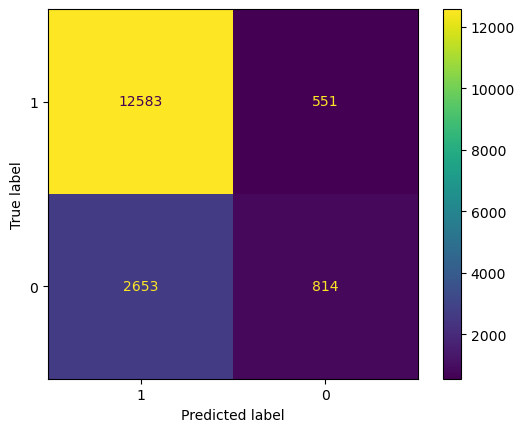

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay

confusion_matrix = ConfusionMatrixDisplay.from_estimator(LogisticReg, X_test, y_test,labels=[1, 0])

From our confusion matrix and the below picture, calculate precision, recall and accuracy : 
- precision: 23142 / (23142 + 7269) = 23142 / 30411 = 75.94%
- recall: 23142 / (13150 + 23142) = 23142 / 36292 = 63.77%
- accuracy: (32719 + 23142) / 76280 = 55861 / 76280 = 73.23%


Let's calculate the percent of churners your model correctly detected :\
    number_churners_correctly_detected / number_of_churners = 32719 / (32719 + 7269) = 32504 / 39988 = 81.82%

Not bad at all, we have now a model to identify 81.82% of churners :)

### We can now get the probability to repurchase or not (column not churner)

In [15]:
proba = pd.DataFrame(LogisticReg.predict_proba(X_test), columns=["Churner", "Not churner"], index=test_customers_ids)
proba

,Churner,Not churner
customers_id,,
72404,0.245935,0.754065
6385,0.520757,0.479243
212336,0.280575,0.719425
258775,0.229754,0.770246
65390,0.361772,0.638228
...,...,...
216278,0.111484,0.888516
251423,0.504655,0.495345
283983,0.539228,0.460772


We can filter this dataframe on customers who have between 20% and 50% probability to re purchase.

Customers with a probability of less than 20% to repurchase are considered lost.

In [16]:
proba[(proba["Not churner"] >= 0.2) & (proba["Not churner"] < 0.5)]

,Churner,Not churner
customers_id,,
6385,0.520757,0.479243
260363,0.541923,0.458077
161347,0.531263,0.468737
115403,0.518453,0.481547
226973,0.529875,0.470125
...,...,...
27040,0.537627,0.462373
69883,0.539353,0.460647
251423,0.504655,0.495345


**You now have a model that predicts churners!**

Using this model, suggest a process that can be implemented at GreenWeez to help the company reduce the churn rate.
